In [1]:
import sys

!{sys.executable} -m pip install tensorflow==1.12.0

    100% |████████████████████████████████| 62.0MB 24kB/s  eta 0:00:01    62% |████████████████████            | 38.9MB 13.8MB/s eta 0:00:02
    100% |████████████████████████████████| 3.1MB 424kB/s eta 0:00:01
    100% |████████████████████████████████| 1.2MB 880kB/s ta 0:00:011
  Found existing installation: protobuf 3.5.2.post1
    Uninstalling protobuf-3.5.2.post1:
      Successfully uninstalled protobuf-3.5.2.post1
  Found existing installation: tensorboard 1.7.0
    Uninstalling tensorboard-1.7.0:
      Successfully uninstalled tensorboard-1.7.0
  Found existing installation: tensorflow 1.7.0
    Uninstalling tensorflow-1.7.0:
      Successfully uninstalled tensorflow-1.7.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook, tqdm
import matplotlib.pyplot as plt

/Users/felixgaschi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
class CommNet:
    
    def __init__(self, sess, N, J, embedding_size = 128, lr = 1e-3, training_mode = 'supervised', alpha = 0.03):
        
        self.N = N
        self.J = J
        self.embedding_size = embedding_size
        
        self.build_controler()
        
        self.training_mode = training_mode
        
        if training_mode == 'supervised':
            self.build_supervised()
            with tf.variable_scope('Supervised_optimizer'):
                self.train_op = tf.train.AdamOptimizer(lr).minimize(self.supervised_loss)
                
        elif training_mode == 'reinforce':
            self.alpha = 0.03
            self.build_reinforce()
            with tf.variable_scope('Reinforce_optimizer'):
                self.train_op =  tf.train.AdamOptimizer(lr).minimize(self.reinforce_loss)
            
        else:
            raise(ValueError("Unknown training mode: %s" % training_mode))
        
        print("All variables")
        for var in tf.global_variables():
            print(var)
            
        
        self.sess = sess
        self.sess.run(tf.global_variables_initializer())
        
    def encode(self, inputs):
        
        with tf.variable_scope('Encoder'):
        
            identity_embeddings = tf.get_variable("identity_embeddings",
                                             [self.N, self.embedding_size])
            
            self.embedded_identities = tf.nn.embedding_lookup(identity_embeddings, inputs)
        
            
        return tf.unstack(self.embedded_identities, axis = 1)
    
    def build_f(self, name, h, c, h0 = None):
        
        with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
            
            if h0 is not None:
                
                b1 = tf.get_variable('b1', shape = (1, self.embedding_size))
                W1 = tf.get_variable('W1', shape = (3 * self.embedding_size,
                                                  self.embedding_size))
                
                W2 = tf.get_variable('W2', shape = (self.embedding_size,
                                                  self.embedding_size))
                
                concat = tf.concat([h, c, h0], axis = 1)
            
            else:
                b1 = tf.get_variable('b1', shape = (1, self.embedding_size))
                
                W1 = tf.get_variable('W1', shape = (2 * self.embedding_size,
                                                  self.embedding_size))
                
                W2 = tf.get_variable('W2', shape = (self.embedding_size,
                                                  self.embedding_size))
                
                concat = tf.concat([h, c], axis = 1)
            
            b2 = tf.get_variable('b2', shape = (1, self.embedding_size))
            
            dense1 =tf.nn.relu(tf.einsum("ij,jk->ik", concat, W1) + b1)
            dense2 = tf.nn.relu(tf.einsum("ij,jk->ik", dense1, W2) + b2)
            
            return dense2
        
    def decode(self, h):
        
        with tf.variable_scope('Decoder', reuse = tf.AUTO_REUSE):
            
            W = tf.get_variable('W', shape = (self.embedding_size,
                                                  self.J))
            
            b = tf.get_variable('b', shape = (1, self.J))
            
            policy_logit = tf.einsum("ij,jk->ik", h, W) + b
        
            return policy_logit
    
    
    def communicate(self, h_seq):
        
        return tf.add_n(h_seq) / (self.J - 1)
    
    def sample_actions(self, policy_logit):
        
        action = tf.multinomial(policy_logit, num_samples = 1)
        
        return action
    
        
    def build_controler(self):
        
        self.inputs = tf.placeholder(tf.int32, shape = (None, self.J))
        
        h0_seq = self.encode(self.inputs)
        c0_seq = [self.communicate([h0_seq[j] for j in range(self.J) if j != i]) for i in range(self.J)]
        
        h1_seq = [self.build_f("Comm_step_1", h0_seq[j], c0_seq[j], None) for j in range(self.J)]
        c1_seq = [self.communicate([h1_seq[j] for j in range(self.J) if j != i]) for i in range(self.J)]
        
        h2_seq = [self.build_f("Comm_step_2", h1_seq[j], c1_seq[j], h0_seq[j]) for j in range(self.J)]
        
        self.layers = {'h0_seq': h0_seq, 'c0_seq': c0_seq, 'h1_seq': h1_seq, 'c1_seq':c1_seq, 'h2_seq': h2_seq}
        
        
        self.policy_logit_seq = [self.decode(h2) for h2 in h2_seq]
        
        self.proba_seq = [tf.nn.softmax(policy_logit, axis = 1) for policy_logit in self.policy_logit_seq]
        
        self.action_seq = [self.sample_actions(policy_logit) for policy_logit in self.policy_logit_seq]
        
        self.one_hot_action_seq = [tf.one_hot(action, depth = self.J) for action in self.action_seq]
        
        
        
    def build_supervised(self):
        
        assert self.training_mode == 'supervised', 'Wrong training mode'
        
        self.targets = tf.placeholder(tf.int32, shape = (None, self.J))
        unstacked_targets = tf.unstack(self.targets, axis = 1)
        
        supervised_loss_seq = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_targets[j],
                                                                                   logits=self.policy_logit_seq[j])
                                    for j in range(self.J)]
        
        self.supervised_loss = tf.reduce_mean(supervised_loss_seq)
        
        
    def supervised_train(self, X, y, val_X, val_y, env, batch_size = 32, epochs = 1):
        
        assert self.training_mode == 'supervised', 'Wrong training mode'
        
        n = X.shape[0]
        
        val_n = val_X.shape[0]
        
        data_inds = np.array(range(n))
        for ep in range(1, epochs + 1):
            np.random.shuffle(data_inds)
            supervised_loss_sum = 0
            reward_sum = 0
            for i in tqdm_notebook(range(0, n, batch_size), "Epoch: %d" % ep):
                inds_batch = data_inds[i:i+batch_size]
                X_batch = X[inds_batch]
                y_batch = y[inds_batch]
                _, supervised_loss, one_hot_action_seq = sess.run([self.train_op, self.supervised_loss, self.one_hot_action_seq], feed_dict={self.inputs: X_batch, self.targets: y_batch})
                supervised_loss_sum += supervised_loss * batch_size
                reward_sum += env.get_reward(one_hot_action_seq)
            
            print("loss = %f" % (supervised_loss_sum / n))
            print("reward = %f" % (reward_sum / n))
            print()
            
            val_supervised_loss, val_one_hot_action_seq = sess.run([self.supervised_loss, self.one_hot_action_seq], feed_dict={self.inputs: val_X, self.targets: val_y})
            print('val loss = %f' % (val_supervised_loss))
            print('val reward = %f' % (env.get_reward(val_one_hot_action_seq) / val_n))
            

    def build_reinforce(self):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        
        self.state_q_val_seq = tf.placeholder(tf.float32, shape = (None, self.J, self.J))
        
        self.reward_sum_values = tf.placeholder(tf.float32, shape = (None,))
        self.advantage_values = tf.placeholder(tf.float32, shape = (None,))
  
        
        self.action_taken = tf.placeholder(tf.int32, shape = (None, self.J))
        unstacked_action_taken = tf.unstack(self.action_taken, axis = 1)
        one_hot_action_taken_seq = [tf.one_hot(action, depth = self.J, dtype = tf.int32) for action in unstacked_action_taken]
        
        self.neg_log_p_seq = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_action_taken[j],
                                                    logits=self.policy_logit_seq[j]) for j in range(self.J)]
        
        neg_log_p_sums = tf.reduce_sum(self.neg_log_p_seq, axis = 0)
        
        
        stacked_proba_seq = tf.stack(self.proba_seq, axis = 1)
        
        baseline = tf.einsum('ijk, ijk-> ij', self.state_q_val_seq, stacked_proba_seq)
        baseline = tf.reduce_mean(baseline, axis = 1)
        
        #surrogate loss (- dtheta)
        advantage = self.reward_sum_values - baseline
    
        self.reinforce_loss =  tf.multiply(neg_log_p_sums, self.advantage_values)
        self.reinforce_loss += self.alpha * tf.square(advantage)
        self.reinforce_loss = tf.reduce_sum(self.reinforce_loss, axis = 0)
        
        
    def take_action(self, state):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        action_seq, proba_seq = self.sess.run([self.action_seq, self.proba_seq], {self.inputs: [state]})
        
        return [a[0,0] for a in action_seq], np.array(proba_seq)
    
    def reinforce_train(self, env, n_episodes, T):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        
        history = {'reward' : [],  'loss': []}
        
        q_reward_sum = np.zeros((self.N, self.J))
        q_state_action_count = np.zeros((self.N, self.J))
        q_val = np.zeros((self.N, self.J))
    
        
        for _ in tqdm(range(n_episodes), "REINFORCE"):
            
            
            state_seq, action_seq, reward_seq, proba_seq = policy_rollout(T, env, self)
            episode_len = reward_seq.shape[0]
            
            history['reward'].append(np.mean(reward_seq))
        
            state_q_val_seq = np.array([q_val[state] for state in state_seq])
            
            baseline = np.einsum('ijk, ijk-> ij', state_q_val_seq, proba_seq)
            
            baseline = baseline.mean(axis = 1)
            
            reward_sum_values = np.array([reward_seq[t:].sum() for t in range(episode_len)])
            advantage_values = np.array([reward_sum_values[t] - baseline[t] for t in range(episode_len)])          
            
            
            feed_dict = {}
            feed_dict[self.inputs] = state_seq
            feed_dict[self.state_q_val_seq] = state_q_val_seq
            feed_dict[self.reward_sum_values] = reward_sum_values
            feed_dict[self.advantage_values] = advantage_values
            feed_dict[self.action_taken] = action_seq
            
            _, loss = self.sess.run([self.train_op, self.reinforce_loss], feed_dict = feed_dict)
            
            history['loss'].append(loss)
            
            # udpate_q_val
            for i in range(episode_len):
                
                state = state_seq[i]
                action = action_seq[i]
                
                cummul_reward = reward_seq[i:].sum()
                q_state_action_count[state, action] += 1
                q_reward_sum[state, action] += cummul_reward
            
            q_val = q_reward_sum/np.maximum(1,q_state_action_count)
            
            
        return history, q_val
            
            
            
            
            
            
            
        

In [4]:
class LeverEnv:
    
    def __init__(self, N, J):
        
        self.J = J
        self.N = N
        
    def reset(self):
        
        state = np.random.choice(self.N, size = self.J, replace = False)
        
        terminal_state = False
        
        return state, terminal_state
    
    def get_reward(self, one_hot_action_seq):        
        
        reward = np.sum(np.sum(one_hot_action_seq, axis = 0) > 0) /self.J
        
        return reward
        
    def step(self, state, action):
        
        next_state = np.random.choice(self.N, size = self.J, replace = False)
        
        one_hot_action_seq = np.zeros((self.J, self.J))
        one_hot_action_seq[range(self.J), action] = 1
        reward = self.get_reward(one_hot_action_seq)
        
        terminal_state = False
        
        return next_state, reward, terminal_state
        

In [5]:
# data generation for supervised learning
def generate_data(n, N, J):
    
    X = np.empty((n, J), dtype = int)
    y= np.empty((n,J), dtype = int)
    
    for i in range(n):
        
        X[i] = np.random.choice(N, size = J, replace = False)
        sorted_args = np.argsort(X[i])
        y[i] = np.argsort(sorted_args)
        
    return X, y

In [6]:
# episode generation for reinforcement learning
def policy_rollout(T, env, agent):
    
    state_seq = []
    action_seq = []
    reward_seq = []
    proba_seq = []
    
    
    state, terminal_state = env.reset()
    
    t = 0
    
    while not terminal_state and t < T:
        t +=1
        
        state_seq.append(state)
        action, proba = agent.take_action(state)
        
        state, reward, terminal_state = env.step(state, action)
        
        
        action_seq.append(action)
        reward_seq.append(reward)
        proba_seq.append(proba)
        
    return np.array(state_seq), np.array(action_seq), np.array(reward_seq), np.squeeze(np.array(proba_seq))

In [7]:
N = 500
J = 5

In [190]:
batch_size = 32
n = batch_size * 1000
X, y = generate_data(n, N, J)
val_X, val_y = generate_data(500, N, J)

In [8]:
tf.reset_default_graph()
with tf.Session() as sess:
    commNet = CommNet(sess, N, J, lr = 1e-3, embedding_size= 128, training_mode = 'reinforce', alpha = 0.03)
    env = LeverEnv(N, J)
    #commNet.supervised_train(X, y, val_X, val_y, env, batch_size = batch_size, epochs = 30)
    
    history, q_val = commNet.reinforce_train(env, n_episodes = 5000, T = 64)
    state_seq, action_seq, reward_seq, proba_seq = policy_rollout(T = 64, env = env, agent = commNet)

REINFORCE:   0%|          | 0/5000 [00:00<?, ?it/s]

All variables
<tf.Variable 'Encoder/identity_embeddings:0' shape=(500, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_1/b1:0' shape=(1, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_1/W1:0' shape=(256, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_1/W2:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_1/b2:0' shape=(1, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_2/b1:0' shape=(1, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_2/W1:0' shape=(384, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_2/W2:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_2/b2:0' shape=(1, 128) dtype=float32_ref>
<tf.Variable 'Decoder/W:0' shape=(128, 5) dtype=float32_ref>
<tf.Variable 'Decoder/b:0' shape=(1, 5) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/beta2_power:0' shape=() dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Encoder/identity_embeddings/Adam:0' shape=(500, 128) dtype=fl

REINFORCE: 100%|██████████| 5000/5000 [11:07<00:00,  7.49it/s]


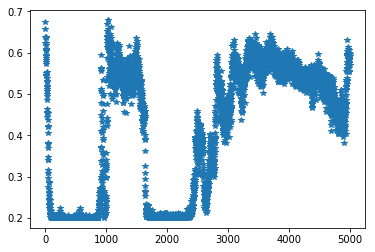

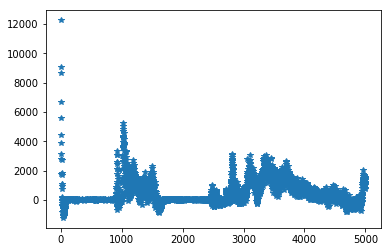

In [9]:
plt.plot(history['reward'], '*')
plt.show()
plt.plot(history['loss'], '*')
plt.show()

In [10]:
!notifier